# Chapter 8: The Naive Bayes Classifier

In [33]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt
from dmba import classificationSummary, gainsChart

In [117]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/min/OneDrive/teaching/DS110/dmba/')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

## Table 8.4

In [118]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
delays_df

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime


In [119]:
delays_df.dtypes

CRS_DEP_TIME      int64
CARRIER          object
DEP_TIME          int64
DEST             object
DISTANCE          int64
FL_DATE          object
FL_NUM            int64
ORIGIN           object
Weather           int64
DAY_WEEK          int64
DAY_OF_MONTH      int64
TAIL_NUM         object
Flight Status    object
dtype: object

In [120]:
# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins scheduled departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors], drop_first=False)
y = (delays_df[outcome] == 'delayed').astype(int)
X

,DAY_WEEK_1,DAY_WEEK_2,DAY_WEEK_3,DAY_WEEK_4,DAY_WEEK_5,DAY_WEEK_6,DAY_WEEK_7,CRS_DEP_TIME_6,CRS_DEP_TIME_7,CRS_DEP_TIME_8,...,DEST_JFK,DEST_LGA,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2198,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2199,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [121]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2196    0
2197    0
2198    0
2199    0
2200    0
Name: Flight Status, Length: 2201, dtype: int64

In [122]:
y.value_counts()

0    1773
1     428
Name: Flight Status, dtype: int64

In [123]:
428/(1773+428)

0.19445706497046797

In [124]:
# y=1 if 'delayed', y=0 if 'ontime'
classes = ['ontime', 'delayed']

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# alpha, default=1.0   Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
# See how to choose alpha: 
# https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn

delays_nb = MultinomialNB(alpha=1)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_train_pred = delays_nb.predict(X_train)
y_valid_pred = delays_nb.predict(X_valid)

In [125]:
predProb_valid

array([[0.54661434, 0.45338566],
       [0.96925484, 0.03074516],
       [0.77522729, 0.22477271],
       ...,
       [0.78235249, 0.21764751],
       [0.97244394, 0.02755606],
       [0.9580871 , 0.0419129 ]])

In [126]:
y_valid_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [127]:
delays_df.CRS_DEP_TIME

0       15
1       16
2       12
3       17
4       10
        ..
2196     6
2197    17
2198    16
2199    14
2200    17
Name: CRS_DEP_TIME, Length: 2201, dtype: category
Categories (16, int64): [6, 7, 8, 9, ..., 18, 19, 20, 21]

In [128]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = delays_df['Flight Status']
classes = list(y.cat.categories)
# y=0 if 'delayed', y=1 if 'ontime'

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=1)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_train_pred = delays_nb.predict(X_train)
y_valid_pred = delays_nb.predict(X_valid)

In [129]:
y

0       ontime
1       ontime
2       ontime
3       ontime
4       ontime
         ...  
2196    ontime
2197    ontime
2198    ontime
2199    ontime
2200    ontime
Name: Flight Status, Length: 2201, dtype: category
Categories (2, object): ['delayed', 'ontime']

In [131]:
classes

['delayed', 'ontime']

In [130]:
predProb_valid

array([[0.45338566, 0.54661434],
       [0.03074516, 0.96925484],
       [0.22477271, 0.77522729],
       ...,
       [0.21764751, 0.78235249],
       [0.02755606, 0.97244394],
       [0.0419129 , 0.9580871 ]])

## Table 8.5
First construct a frequency table and then convert it to the propability table

In [134]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('display.precision', 4)
# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('display.precision')

# apply function (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html):
# Run any user-defined function on a DataFrame or Series
# Apply a function either row-wise (axis=1) or column-wise (axis=0) on a DataFrame
# Perform index alignment while applying the function
# Perform aggregation with user-defined functions (however, we usually prefer agg or transform in these cases)
# Perform element-wise transformations
# Broadcast aggregated results to original rows (see the result_type argument).
# Accept positional/keyword arguments to pass to the user-defined functions.

# lambda argument_list: expression
# The argument list consists of a comma separated list of arguments and 
# the expression is an arithmetic expression using these arguments. 
# You can assign the function to a variable to give it a name.
# The following example of a lambda function returns the sum of its two arguments:
# >>> f = lambda x, y : x + y
# >>> f(1,1)
# 2

#  axis=0 is "column-wise" and axis=1 "row-wise".
# It specifies the axis along which the means are computed. By default axis=0. 
# This is consistent with the numpy.mean usage when axis is specified explicitly 
# (in numpy.mean, axis==None by default, which computes the mean value over the 
# flattened array) , in which axis=0 along the rows (namely, index in pandas), 
# and axis=1 along the columns. For added clarity, one may choose to specify 
# axis='index' (instead of axis=0) or axis='columns' (instead of axis=1).

# text() function is used to add text in the Drawing object. 
# It takes x and y coordinates and string that we want to write on (x, y) position.


ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME        6       7       8       9      10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

In [135]:
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977
# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023
print('P_hat_delayed ~ ', P_hat_delayed)
print('P_hat_ontime ~ ', P_hat_ontime)

print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P_hat_delayed ~  2.0548742506526157e-05
P_hat_ontime ~  0.00033326464123921066
P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


## Table 8.6

In [136]:
# scoring the example flight (probability and class)
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) & (X_valid.CRS_DEP_TIME_10 == 1) & 
        (X_valid.DEST_LGA == 1) & (X_valid.ORIGIN_DCA == 1))

print(df[mask])

      actual predicted        0        1
1225  ontime    ontime  0.06116  0.93884


In [137]:
mask

1276    False
1446    False
335     False
1458    False
2038    False
        ...  
460     False
2063    False
159     False
2027    False
1247    False
Length: 881, dtype: bool

In [138]:
df

,actual,predicted,0,1
1276,ontime,ontime,0.453386,0.546614
1446,ontime,ontime,0.030745,0.969255
335,ontime,ontime,0.224773,0.775227
1458,ontime,ontime,0.032467,0.967533
2038,ontime,ontime,0.019880,0.980120
...,...,...,...,...
460,ontime,ontime,0.261893,0.738107
2063,ontime,ontime,0.213976,0.786024
159,ontime,ontime,0.217648,0.782352
2027,delayed,ontime,0.027556,0.972444


## Table 8.7

In [139]:
classificationSummary(y_train, y_train_pred, class_names=classes) 
print()
classificationSummary(y_valid, y_valid_pred, class_names=classes) 

Confusion Matrix (Accuracy 0.7985)

        Prediction
 Actual delayed  ontime
delayed      54     207
 ontime      59    1000

Confusion Matrix (Accuracy 0.7832)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      50     664


## Figure 8.1

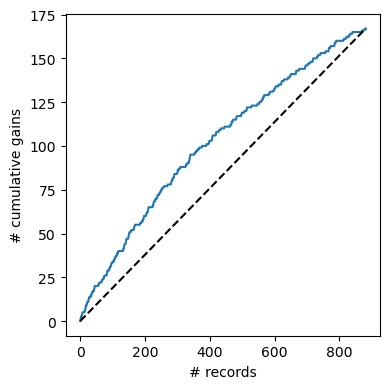

In [140]:
df = pd.DataFrame({'actual': 1 - y_valid.cat.codes, 'prob': predProb_valid[:, 0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)

plt.tight_layout()
plt.show()

In [141]:
import numpy as np
np.exp(delays_nb.feature_log_prob_)
# feature_log_prob_ for interpreting MultinomialNB as a linear model. Too theoretical for this class.

array([[0.03800298, 0.02980626, 0.02309985, 0.02533532, 0.03725782,
        0.01415797, 0.03204173, 0.00745156, 0.01117735, 0.01341282,
        0.00447094, 0.00670641, 0.00298063, 0.01043219, 0.00968703,
        0.00819672, 0.04023845, 0.01490313, 0.03055142, 0.00447094,
        0.02011923, 0.00372578, 0.01788376, 0.01639344, 0.10208644,
        0.07824143, 0.07451565, 0.03949329, 0.08271237, 0.0119225 ,
        0.06184799, 0.01937407, 0.04396423, 0.00223547, 0.04321908,
        0.00372578, 0.01415797],
       [0.02494374, 0.02831958, 0.02888222, 0.03582146, 0.03375844,
        0.0271943 , 0.02100525, 0.01256564, 0.01275319, 0.01706677,
        0.01144036, 0.01050263, 0.00693923, 0.01331583, 0.01500375,
        0.01162791, 0.02344336, 0.01556639, 0.02006752, 0.00712678,
        0.00806452, 0.00543886, 0.01069017, 0.01219055, 0.12884471,
        0.05813953, 0.05307577, 0.03113278, 0.11496624, 0.00712678,
        0.04576144, 0.04069767, 0.02344336, 0.00225056, 0.03375844,
        0.00356

In [142]:
y_valid

1276     ontime
1446     ontime
335      ontime
1458     ontime
2038     ontime
         ...   
460      ontime
2063     ontime
159      ontime
2027    delayed
1247     ontime
Name: Flight Status, Length: 881, dtype: category
Categories (2, object): ['delayed', 'ontime']

In [143]:
y_valid.cat.codes

1276    1
1446    1
335     1
1458    1
2038    1
       ..
460     1
2063    1
159     1
2027    0
1247    1
Length: 881, dtype: int8

In [144]:
predProb_valid

array([[0.45338566, 0.54661434],
       [0.03074516, 0.96925484],
       [0.22477271, 0.77522729],
       ...,
       [0.21764751, 0.78235249],
       [0.02755606, 0.97244394],
       [0.0419129 , 0.9580871 ]])

In [145]:
df.actual

0      1
1      1
2      0
3      1
4      0
      ..
876    0
877    0
878    1
879    0
880    0
Name: actual, Length: 881, dtype: int8

In [146]:
df.actual.sum()

167

In [147]:
len(df.actual)

881

In [148]:
pd.Series([0])

0    0
dtype: int64

In [149]:
df.actual.cumsum()

0        1
1        2
2        2
3        3
4        3
      ... 
876    166
877    166
878    167
879    167
880    167
Name: actual, Length: 881, dtype: int64

In [150]:
#list(range(len(df.actual)))